# Using learning rate schedulers

The notebook demonstrates how to configure simple learning rate (LR) schedulers with Hyrax. A list of LR schedulers can be found in the PyTorch documentation here: https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LRScheduler.html.

In [1]:
# setup

from hyrax import Hyrax
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import pickle


def show_confusion_matrix(test_data, predicted_classes):
    y_true = test_data[b"labels"]
    y_pred = predicted_classes.tolist()

    correct = 0
    for t, p in zip(y_true, y_pred):
        correct += t == p

    print("\nAccuracy for test dataset:", correct / len(y_true))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


data_request_definition = {
    "train": {
        "data": {
            "dataset_class": "HyraxCifarDataset",
            "data_location": "./data",
            "fields": ["image", "label"],
            "primary_id_field": "object_id",
        },
    },
    "infer": {
        "data": {
            "dataset_class": "HyraxCifarDataset",
            "data_location": "./data",
            "fields": ["image", "object_id"],
            "primary_id_field": "object_id",
            "dataset_config": {
                "use_training_data": False,
            },
        },
    },
}

## The default scheduler in Hyrax

When no scheduler is specified in the user-defined config or in the model, Hyrax uses an [ExponentialLR](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html) scheduler with `gamma = 1`; this means it simply multiplies the starting learning rate by 1 on each epoch, which leads to a constant learning rate across all epochs.

We begin by setting up and training a HyraxCNN model with the CIFAR10 dataset, like in the [Getting Started](<getting_started.ipynb>) notebook.

In [ ]:
h = Hyrax()
h.set_config("model.name", "HyraxCNN")
h.set_config("data_request", data_request_definition)
trained_model = h.train()

In [ ]:
with open("./data/cifar-10-batches-py/test_batch", "rb") as f_in:
    test_data = pickle.load(f_in, encoding="bytes")

## Performance of the model

By using the default learning rate scheduler, the resulting accuracy on the test set and confusion matrix shouldn't be much different from what is in the [Getting Started](<getting_started.ipynb>) notebook

In [ ]:
inference_results = h.infer()

In [5]:
predicted_classes = np.argmax(inference_results, axis=1)


Accuracy for test dataset: 0.4564


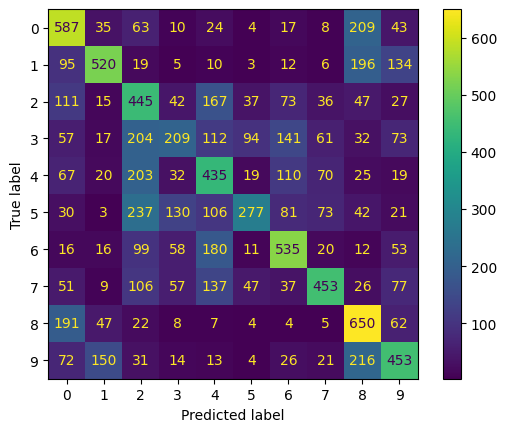

In [6]:
show_confusion_matrix(test_data, predicted_classes)

Both the overall accuracy and the confusion matrix resemble what we see in the [Getting Started](<getting_started.ipynb>) notebook.

## Specifying learning rate parameters

Now let's see what happens when we modify the ExponentialLR scheduler parmeters. We will update `gamma` to be `0.9`; this means the scheduler will multiply the previous learning rate by `0.9` to determine the new rate before beginning each epoch with the base learning rate being used on the very first epoch.

Note: All PyTorch learning rate schedulers also accept an `optimizer` and `last_epoch` parameter. Hyrax will provide these automatically using the model's optimizer and an appropriate value for `last_epoch`.

In [ ]:
h = Hyrax()
h.set_config("model.name", "HyraxCNN")
h.set_config("data_request", data_request_definition)
h.set_config("scheduler", {"name": "torch.optim.lr_scheduler.ExponentialLR"})
h.set_config("'torch.optim.lr_scheduler.ExponentialLR'", {"gamma": 0.9})

Now that we've made a new model with updated parameters for the Exponential LR Scheduler, we'll retrain and infer with the new model.

In [ ]:
trained_model = h.train()

In [ ]:
inference_results = h.infer()

In [10]:
predicted_classes = np.argmax(inference_results, axis=1)


Accuracy for test dataset: 0.4152


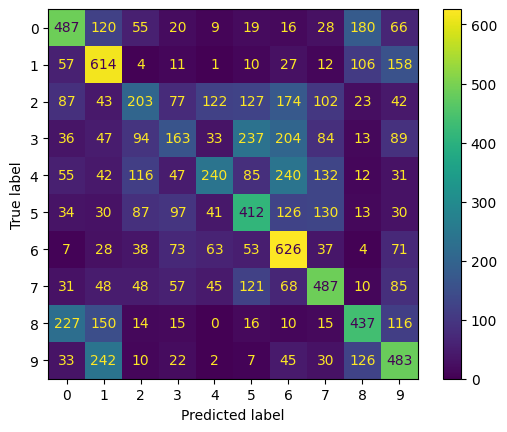

In [11]:
show_confusion_matrix(test_data, predicted_classes)

The results may be a bit worse than without using the learning rate scheduler, but that is to be expected since we didn't really try doing any sort of tuning and just wanted to demonstrate the feature. We can also see the history of the learning rates in TensorBoard to verify that the scheduler did in fact have an effect. Orange curves belong to the original model and red curves pertain to the model with the updated scheduler:

![tensorboard_lr_history_exponential.png](tensorboard_lr_history_exponential.png)

## Defining a CosineAnnealingLR

Hyrax offers support for more than just the ExponentialLR. Defining other learning rate schedulers follows the same process. We demonstrate this with [CosineAnnealingLR](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html). Any other PyTorch learning rate scheduler can be used in the same way. The list of other schedulers can be seen here: https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LRScheduler.html.

In [ ]:
h = Hyrax()
h.set_config("model.name", "HyraxCNN")
h.set_config("data_request", data_request_definition)
h.set_config("scheduler", {"name": "torch.optim.lr_scheduler.CosineAnnealingLR"})
h.set_config("'torch.optim.lr_scheduler.CosineAnnealingLR'", {"T_max": 10})

In [ ]:
trained_model = h.train()

In [ ]:
inference_results = h.infer()

In [15]:
predicted_classes = np.argmax(inference_results, axis=1)


Accuracy for test dataset: 0.369


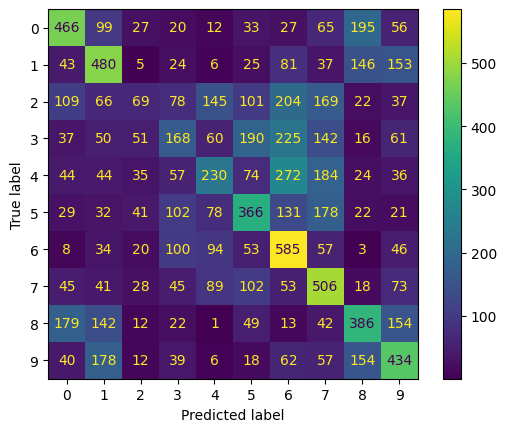

In [16]:
show_confusion_matrix(test_data, predicted_classes)

These results are also worse than before since we didn't do any tuning; the goal is simply to demonstrate using schedulers as a feature. The new pink curves on Tensorboard are from the model using CosineAnnealingLR:

![tensorboard_lr_history_cosine.png](tensorboard_lr_history_cosine.png)

## Note on ChainedScheduler and SequentialLR

Hyrax config does not support the [ChainedScheduler](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ChainedScheduler.html) or [SequentialLR](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.SequentialLR.html) scheduler; those must be directly defined in the model if desired to be used. This notebook will walk through the default LR used in Hyrax as well as defining an ExponentialLR defined in the config.